# Text-driven emotion editing in images

## CSC_52002_EP Project - École Polytechnique

### Hamza Azzouzi, Rodrigue Reibel


The objective of this project is to perform image editing on portraits, focusing on human emotions—making people appear happy, sad, angry, surprised, etc.

We employ text-driven GAN editing. Specifically, we use a StyleGAN model pretrained on the FFHQ dataset and optimize a CLIP-based loss function, following the approach of the StyleCLIP paper. Our editing process relies on latent optimization via gradient descent in the $\mathbb W^+$ latent space of StyleGAN.

In [2]:
from argparse import Namespace
import time
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.amp import autocast
from tqdm import tqdm
import clip
from tabulate import tabulate

from utils.common import tensor2im
from utils.alignment import run_alignment
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.
from criteria.clip_loss import CLIPLoss
from criteria.id_loss import IDLoss

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_PATH = "input_images/input_img.jpg"
RESIZE_DIMS = (256, 256)

## 1. Load pretrained models

### 1.1. Load the pixel2Style2pixel model 

The pSp model contains a pretrained Encoder4Editing ($e4e$) encoder, and a pretrained StyleGAN Generator.

In [3]:
# Define the arguments for the e4e encoder

pretrained_pSp_path = 'pretrained_models/e4e_ffhq_encode.pt'

e4e_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

In [4]:
# Load the pSp model

ckpt = torch.load(pretrained_pSp_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = pretrained_pSp_path
opts['ir_se50_weights'] = 'pretrained_models/model_ir_se50.pth'
opts= Namespace(**opts)
latent_avg = ckpt["latent_avg"]

psp_model = pSp(opts)
psp_model.eval()
psp_model.cuda()

print('Model successfully loaded!')

/tmp/ipykernel_2005588/3793385928.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrained_pSp_path, map_location='cpu')


Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt


/users/eleves-b/2022/rodrigue.reibel/emotion_generation/models/psp.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.opts.checkpoint_path, map_loca

Model successfully loaded!


### 1.2. Load pretrained image emotion classifier

In [5]:
from emotionmmodel.networks.DDAM import DDAMNet

emotion_model = DDAMNet(num_class=7, num_head=2, pretrained=False)
path = "pretrained_models/affecnet7_epoch19_acc0.671.pth"
checkpoint = torch.load(path, map_location=device)
emotion_model.load_state_dict(checkpoint['model_state_dict'])
emotion_model.to(device)
emotion_model.eval()    
val_transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]) 
emotion_loss = torch.nn.CrossEntropyLoss()

## Image transform

def scale_img_for_emotion_model(x):
    # x is shape (B, 3, H, W) in [-1,1]
    x = (x + 1) / 2  # Now in [0,1]
    return x

def normalize_for_emotion_model(x):
    # Normalizing using ImageNet-like mean/std
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

/tmp/ipykernel_2005588/1197914904.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


### 1.3. Load pretrained text emotion classifier

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")
text_model = AutoModelForSequenceClassification.from_pretrained("michellejieli/emotion_text_classifier")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model.to(device)
text_model.eval()  # Set to evaluation mode

def predict_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move tensors to device
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get model predictions
    with torch.no_grad():
        outputs = text_model(**inputs)
    
    # Get probabilities using softmax
    probabilities = F.softmax(outputs.logits, dim=-1)
    
    # Get predicted class
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    emotion_labels = ["anger", "disgust", "fear", "joy", "neutrality", "sadness", "surprise"]
    
    return emotion_labels[predicted_class], probabilities.squeeze().tolist()


/users/eleves-b/2022/rodrigue.reibel/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/eleves-b/2022/rodrigue.reibel/.local/lib/python3.9/site-packages/transformers/utils/generic.py:482: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/users/eleves-b/2022/rodrigue.reibel/.local/lib/python3.9/site-packages/transformers/utils/generic.py:339: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/users/eleves-b/2022/rodrigue.reibel/.local/lib/python3.9/site-packages/transformers/utils/generic.py:339: FutureWarning: `torch.utils._pytree._register_pytr

## 2. StyleGAN inversion

We search for a $w \in \mathbb{W}^+$ such that $G(w)$ closely matches the input image. To achieve this, we use the pretrained Encoder4Editing ($e4e$) model, which is specifically designed to map real images into a latent space where meaningful edits can be applied.

To improve inversion, we then optimize the following objective function using gradient descent, starting from the $e4e$-based inversion initialization:

$$ argmin_{w \in \mathbb{W}^+} \, \lambda_{L2} \left\| G(w) - \text{img} \right\|_2 + \lambda_{ID} \mathcal{L}_{ID}(G(w), \text{img}) \quad , \quad w_0 = e4e(\text{img}) $$

where $\text{img}$ denotes the input image, and the identity loss is :

$$ \mathcal{L}_{ID}(img_1, img_2) = 1 - \langle R(img_1), R(img_2) \rangle $$

where $R$ is a pretrained ArcFace network for face recognition

### 2.1. Encoder4Editing inversion


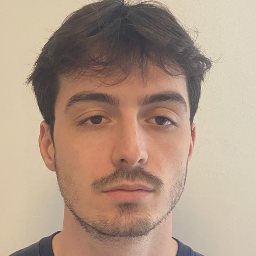

In [7]:
# Load the input image

image_path = "input_images/neutral_RR.jpg"
original_image = Image.open(image_path).convert("RGB")
image = run_alignment(image_path).resize(RESIZE_DIMS)

# show the input image
input_image = e4e_transform(image)
image

In [8]:
# Compute e4e inversion

with torch.no_grad():
    e4e_inverted_latent = psp_model.encoder(input_image.unsqueeze(0).to(device))
if psp_model.opts.start_from_latent_avg:
                if e4e_inverted_latent.ndim == 2:
                    e4e_inverted_latent = e4e_inverted_latent + psp_model.latent_avg.repeat(e4e_inverted_latent.shape[0], 1, 1)[:, 0, :]
                else:
                    e4e_inverted_latent = e4e_inverted_latent + psp_model.latent_avg.repeat(e4e_inverted_latent.shape[0], 1, 1)


## 2.2. Hybrid inversion

Refine e4e inversion with latent optimization

In [9]:
# Parameters of optim

optimization_steps = 100
lambda_percept = 1
lambda_L2 = 0.5
lr = 0.01 
final_lr = 0.001
id_loss = IDLoss(opts)
L2_loss = torch.nn.MSELoss().to(device)


save_img_every_other = optimization_steps // 10
G = psp_model.decoder # StyleGan2 generator

# Initialization with e4e output

w_n = e4e_inverted_latent.clone().detach().requires_grad_(True).to(device) 

optimizer = torch.optim.Adam([w_n], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=optimization_steps, eta_min=final_lr)

with torch.no_grad():
    img_orig, _ = G([w_n], input_is_latent=True)

pbar = tqdm(range(optimization_steps))

imgs = []
losses = []
reference_image = transforms.Resize((1024, 1024))(input_image).unsqueeze(0).cuda()

# Optimization of the latent code

for i in pbar:

    with autocast("cuda"):
        
        optimizer.zero_grad()

        img_gen, _ = G([w_n], input_is_latent=True, randomize_noise=False)

        i_loss = id_loss(img_gen, reference_image)[0]
        l2_loss = L2_loss(img_gen, reference_image)

        loss = i_loss * lambda_percept + l2_loss * lambda_L2 
        losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        scheduler.step()

        if i % save_img_every_other == 0 or i == optimization_steps - 1:
            imgs.append(tensor2im(img_gen.squeeze(0).cpu()))

inverted_latent = w_n.detach()


Loading ResNet ArcFace


/users/eleves-b/2022/rodrigue.reibel/emotion_generation/criteria/id_loss.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.facenet.load_state_dict(torch.load(opts.ir

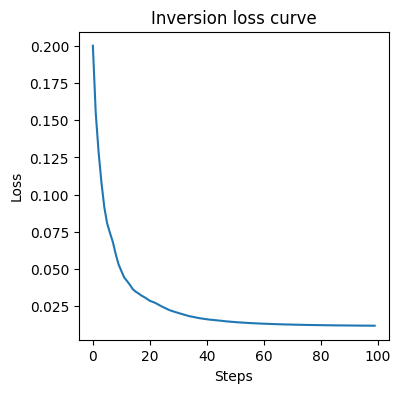

In [10]:
# Plot inversion loss curve

plt.figure(figsize=(4, 4))
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Inversion loss curve")
plt.show()


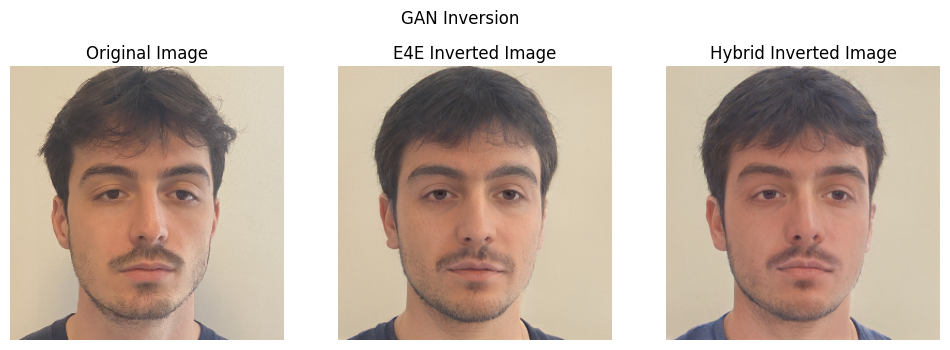

In [11]:
# Visualize the inversion

def visualize_latent(e4e_latent, hybrid_latent, original_image=image, title=None):
    e4e_generated_image, _ = psp_model.decoder([e4e_latent], input_is_latent=True)
    e4e_show_img = tensor2im(e4e_generated_image.squeeze(0).cpu())

    hybrid_generated_image, _ = psp_model.decoder([hybrid_latent], input_is_latent=True)
    hybrid_show_img = tensor2im(hybrid_generated_image.squeeze(0).cpu())

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(e4e_show_img)
    plt.title('E4E Inverted Image')
    plt.axis('off')
    plt.subplot
    plt.subplot(1, 3, 3)
    plt.imshow(hybrid_show_img)
    plt.title('Hybrid Inverted Image')
    plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

visualize_latent(e4e_inverted_latent, inverted_latent, title="GAN Inversion")


## 3. Latent optimization with CLIP loss

Given a source latent code $w_s \in W^+$, and a directive in natural language, or a text prompt $t$, we solve the following optimization problem:

$$ argmin_{w \in \mathbb W^+} \, D_{CLIP}(G(w), t) + \lambda_{L2} \left\| w - w_s \right\|_2 + \lambda_{ID} \mathcal L_{ID}(G(w), G(w_s)) $$

where $G$ is a pretrained StyleGAN generator and $D_{CLIP}$ is the cosine distance between the CLIP embeddings of its two arguments. Similarity to the input image is controlled by the $L^2$ distance in latent space, and by the identity loss.

In [12]:
# Load pretrained models for losses

clip_loss = CLIPLoss(opts)
id_loss = IDLoss(opts)

Loading ResNet ArcFace


╒═════════════╤═══════════╤══════════╤════════════╤════════════╤════════════╤════════════╤═══════════╕
│ Emotion     │   Neutral │    Happy │        Sad │   Surprise │       Fear │    Disgust │     Angry │
╞═════════════╪═══════════╪══════════╪════════════╪════════════╪════════════╪════════════╪═══════════╡
│ Probability │ 0.0150589 │ 0.265616 │ 0.00144257 │   0.633321 │ 0.00742626 │ 0.00101002 │ 0.0761251 │
╘═════════════╧═══════════╧══════════╧════════════╧════════════╧════════════╧════════════╧═══════════╛


Loss: 1.0537: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


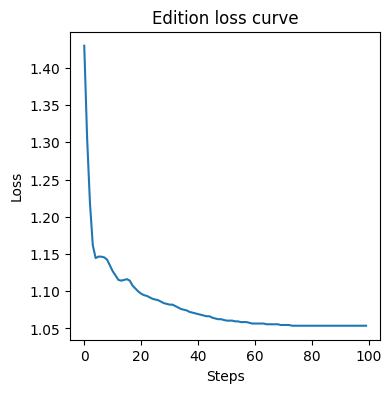

In [13]:
# Prompt for text-guided optimization

prompt = "I just got into Harvard !!!"

# Parameters of optimization

optimization_steps = 100
lambda_L2 = 0.01
lambda_ID = 0.01
lambda_emotion = 0.0
lambda_emotion = 0.2

lr = 0.005 
final_lr = 0.0001
truncation = 0.95

save_img_every_other = optimization_steps // 10
G = psp_model.decoder # StyleGan2 generator

# Initialization

w_start = inverted_latent 

w_n = w_start.clone().detach().requires_grad_(True).to(device)
optimizer = torch.optim.Adam([w_n], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=optimization_steps, eta_min=final_lr)

text_inputs = torch.cat([clip.tokenize(prompt)]).cuda()

# Get emotion distribution from text

emotion, probs = predict_emotion(prompt)

text_classifier_labels = ["anger", "disgust", "fear", "joy", "neutrality", "sadness", "surprise"]
emotion_classifier_labels = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry']

# Match text classifier labels to emotion classifier labels

new_labels = [4, 3, 5, 6, 2, 1, 0]
goal_distribution_list = [0]*7

for i in range(7) :
    goal_distribution_list[i] = probs[new_labels[i]]

goal_distribution = torch.tensor([goal_distribution_list], device=device)

# Print the predicted logit for each label

data = [
    ["Emotion"] + [label for label in emotion_classifier_labels],
    ["Probability"] + goal_distribution.squeeze().tolist()
]

print(tabulate(data, headers="firstrow", tablefmt="fancy_grid"))

with torch.no_grad():
    img_orig, _ = G([w_n], input_is_latent=True)

pbar = tqdm(range(optimization_steps))

imgs = []
losses = []
reference_image = transforms.Resize((1024, 1024))(input_image).unsqueeze(0).cuda()

# Optimization loop

for i in pbar:

    with autocast("cuda"):
        
        optimizer.zero_grad()

        img_gen, _ = G([w_n], input_is_latent=True, randomize_noise=False)

        c_loss = clip_loss(img_gen, text_inputs)
        i_loss = id_loss(img_gen, img_orig)[0] # original
        l2_loss = ((w_start - w_n) ** 2).sum()

        # 1) Scale to [0,1] if needed
        img_for_emotion = scale_img_for_emotion_model(img_gen)
        # 2) Resize to (112, 112)
        img_for_emotion = F.interpolate(img_for_emotion, size=(112, 112), mode='bilinear', align_corners=False)
        # 3) Normalize
        img_for_emotion = normalize_for_emotion_model(img_for_emotion)
        # Now feed directly to emotion model (gradients will flow back!)
        prediction, feat, heads = emotion_model(img_for_emotion)
        e_loss = emotion_loss(prediction, goal_distribution)

        # --- Combine losses ---
        loss = c_loss + lambda_L2 * l2_loss + lambda_ID * i_loss + lambda_emotion * e_loss
        losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        scheduler.step()

        if i % save_img_every_other == 0 or i == optimization_steps - 1:
            imgs.append(tensor2im(img_gen.squeeze(0).cpu()))

final_image = img_gen.detach()
    
# Plot edition loss curve

plt.figure(figsize=(4, 4))
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Edition loss curve")
plt.show()

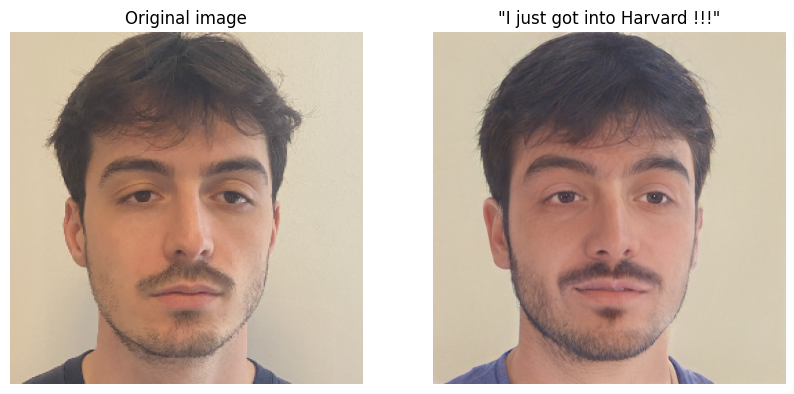

In [14]:
# Plot final image next to original image

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(tensor2im(img_gen.squeeze(0).cpu()))
plt.title(f'"{prompt}"')
plt.axis('off')
plt.show()